# Regresiones para Respuestas Discretas
En esta sesión vamos a analizar una generalización del modelo de regresion lineal que permite modelar un conjunto de datos,  en que la variable a explicar es discreta y las variables explicativas son numéricas o categóricas. Dos ejemplos de ello son los  modelos de regresión logística y regresión de Poisson, que estimaremos en R con ayuda de la función `glm`.


## Regresión Logística
En este caso la variable a explicar es **binaria** y las variables explicativas son numéricas o categóricas. 

**Formalmente:**

Sea $y \in \{0,1\}$ la variable a explicar y $\textbf{x} \in \mathbb{R}^k$ las variables explicativas.

Dos cambios respecto de la regresión lineal: 

- El primero es que $y |\textbf{x}$ se modela como una v.a. con distribución $\textbf{Bernoulli}$ en lugar de una Normal, es decir:

$$p(y |\textbf{x},\beta)= Ber(\mu(\textbf{x}))$$

dónde 

$$\mathbb{E}[y|\textbf{x}] = p(y=1|\textbf{x}) = \mu(\textbf{x})$$

- Y lo segundo es que, al igual que en la regresión lineal, se considera una combinación lineal de las variables explicativas, pero esta combinación lineal es pasada como parámetro a una función $\mu$ que toma valores en el intervalo $[0,1]$, de manera que:

$$\mu(x) = \sigma(\beta^T\textbf{x})$$

dónde $\sigma$ es la función sigmoidal definida por:

$$\sigma(\eta) = \frac{1}{1+exp(-\eta)} = \frac{e^{\eta}}{e^{\eta}+1}$$

y su inversa conocida también como $\textbf{logística}$ o $\textbf{logit}$ es: 

$$\text{logit}(p) = ln\left(\frac{p}{1- p}\right)$$

entonces se cumple que 

$$ \text{logit}(\mu(\textbf{x}))= \text{logit}(\sigma(\beta^T\textbf{x})) = \beta^T\textbf{x}$$

Asi, se obtiene el modelo:



$$\text{logit}(\mathbb{E}[y|\textbf{x}]) = \beta^T\textbf{x}$$

denominado regresión logística, por su similitud con la regresión lineal, aunque es una forma de clasificación mas que una regresión.

El coeficiente $\frac{p}{1-p}$ se denomina suele denominar riesgo (odd en inglés) pues es la tasa entre las probabilidades de respuesta "positiva" y "negativa".


In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(grid))
suppressMessages(library(grDevices))

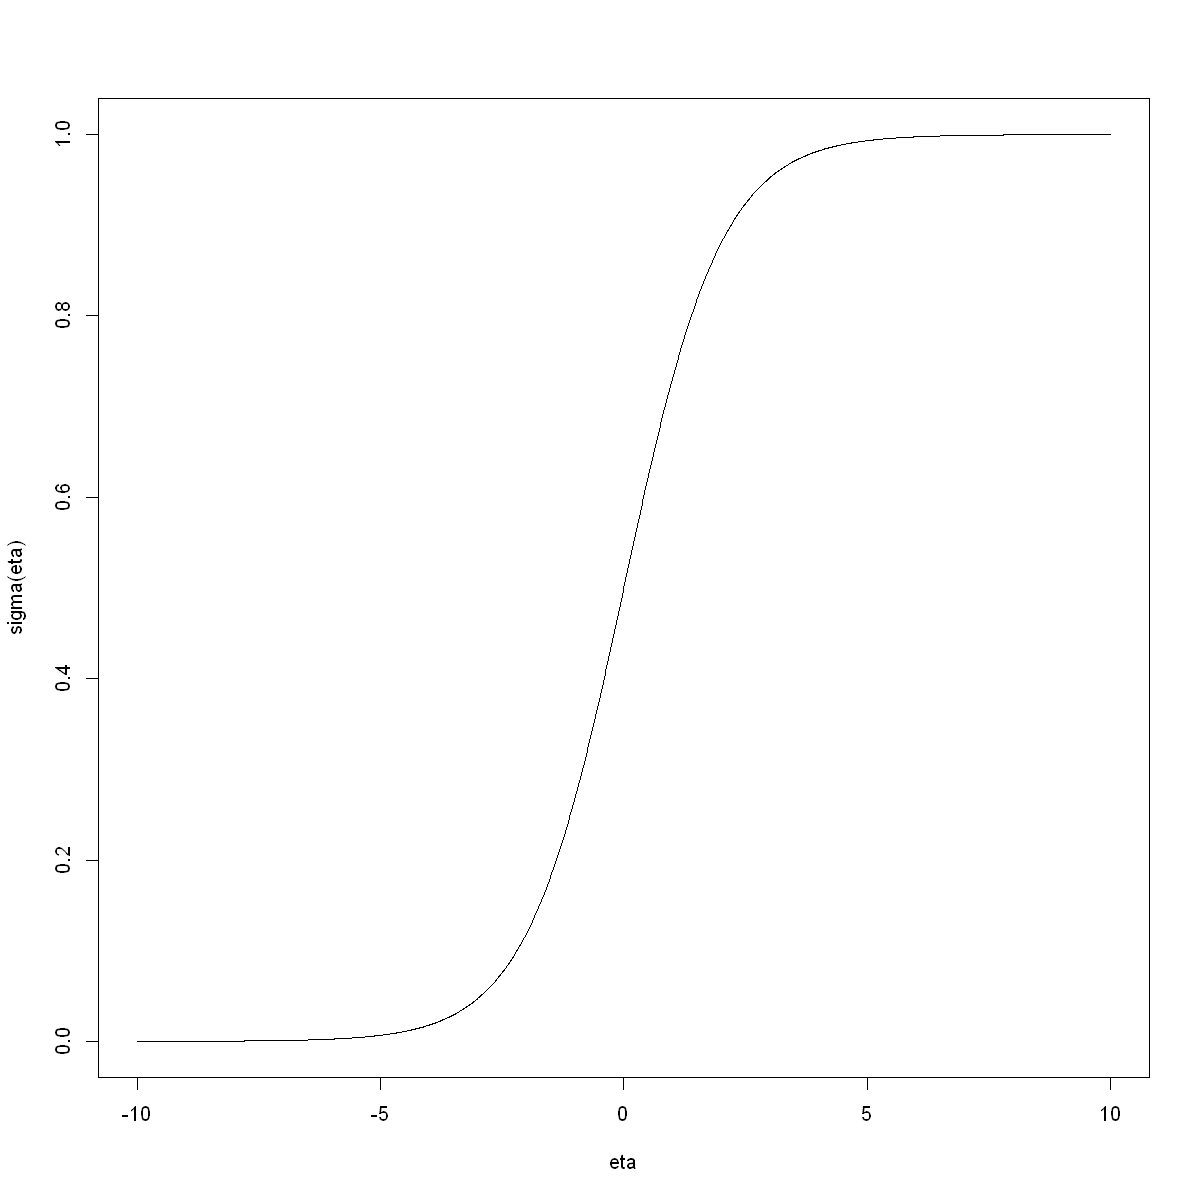

In [2]:
#gráfica de la función sigmoide
options(repr.plot.width=10, repr.plot.height=10)
eta = seq(-10,10,by=0.01)
sigma <- function(x){return( exp(x)/(exp(x)+1))}
plot(eta,sigma(eta),type="l")


### Estimación de parámetros $\beta$
Los parámetros $\beta$ se pueden estimar por máxima verosimilitud.
En efecto, sea la muestra $\{(y_i,\textbf{x}_i), i=1,\cdots,n\}$, se tiene:

$$\begin{array}{lll}
\log \mathcal{L} (\beta) & = &  {\displaystyle \sum_{i=1}^n} y_i \log \sigma(\beta^T \textbf{x}_i) + {\displaystyle \sum_{i=1}^n}  (1-y_i) \log (1- \sigma(\beta^T \textbf{x}_i))\\
&  = &{\displaystyle \sum_{i=1}^n} y_i \log \left(\frac{\sigma(\beta^T \textbf{x}_i)}{1- \sigma(\beta^T \textbf{x}_i)}\right) + {\displaystyle \sum_{i=1}^n}  \log (1- \sigma(\beta^T \textbf{x}_i))\\
& = & {\displaystyle \sum_{i=1}^n}  y_i \beta^T \textbf{x}_i + {\displaystyle \sum_{i=1}^n}  \log (1- e^{\beta^T \textbf{x}_i})
\end{array}$$

A partir de esta función de verosimilitud no es posible obtener de manera analítica los  estimadores máximo verosímiles de $\beta$. Se requiere utilizar algún algoritmo de aproximación como Newton-Raphson para las raices del gradiente de $\log \mathcal{L}(\beta)$ o utilizar directamente el algoritmo del gradiente descendente. 

En el caso de Newton-Raphson las ecuaciones de aproximación quedan:

$$\hat{\beta}^{nuevo} = \hat{\beta}^{viejo} + (X^TW X)^{-1}X^T(\textbf{y} - \hat{\mu})$$

donde $X \in M_{nxk}$ es la matriz de valores de las $k$ variables explicativas en las $n$ observaciones, 

$$\hat{\mu}_i = \frac{e^{X_{i}\hat{\beta}^{viejo}}}{e^{X_{i}\beta^{viejo}}+1}$$

y $W \in M_{nxn}$ es la matriz diagonal con:

$$ w_{ii} = \hat{\mu}_i ( 1- \hat{\mu}_i)$$

Lo criterios de convergencia del método iterativo utilizado para estimar los parámetros pueden ser varios, pero en todos ellos la idea subyacente es que:

$$\hat{\beta}^{nuevo} \approx \hat{\beta}^{viejo} \qquad \mbox{ o } \qquad\log \mathcal{L}(\hat{\beta}^{viejo}) \approx log \mathcal{L} (\hat{\beta}^{nuevo})\qquad\mbox{ o }\qquad \hat{\mu}^{viejo} \approx \hat{\mu}^{nuevo}$$ 


    TrLevel         SAT       
 Min.   :0.0   Min.   :463.0  
 1st Qu.:0.0   1st Qu.:543.5  
 Median :1.0   Median :567.5  
 Mean   :0.7   Mean   :559.5  
 3rd Qu.:1.0   3rd Qu.:582.0  
 Max.   :1.0   Max.   :649.0  

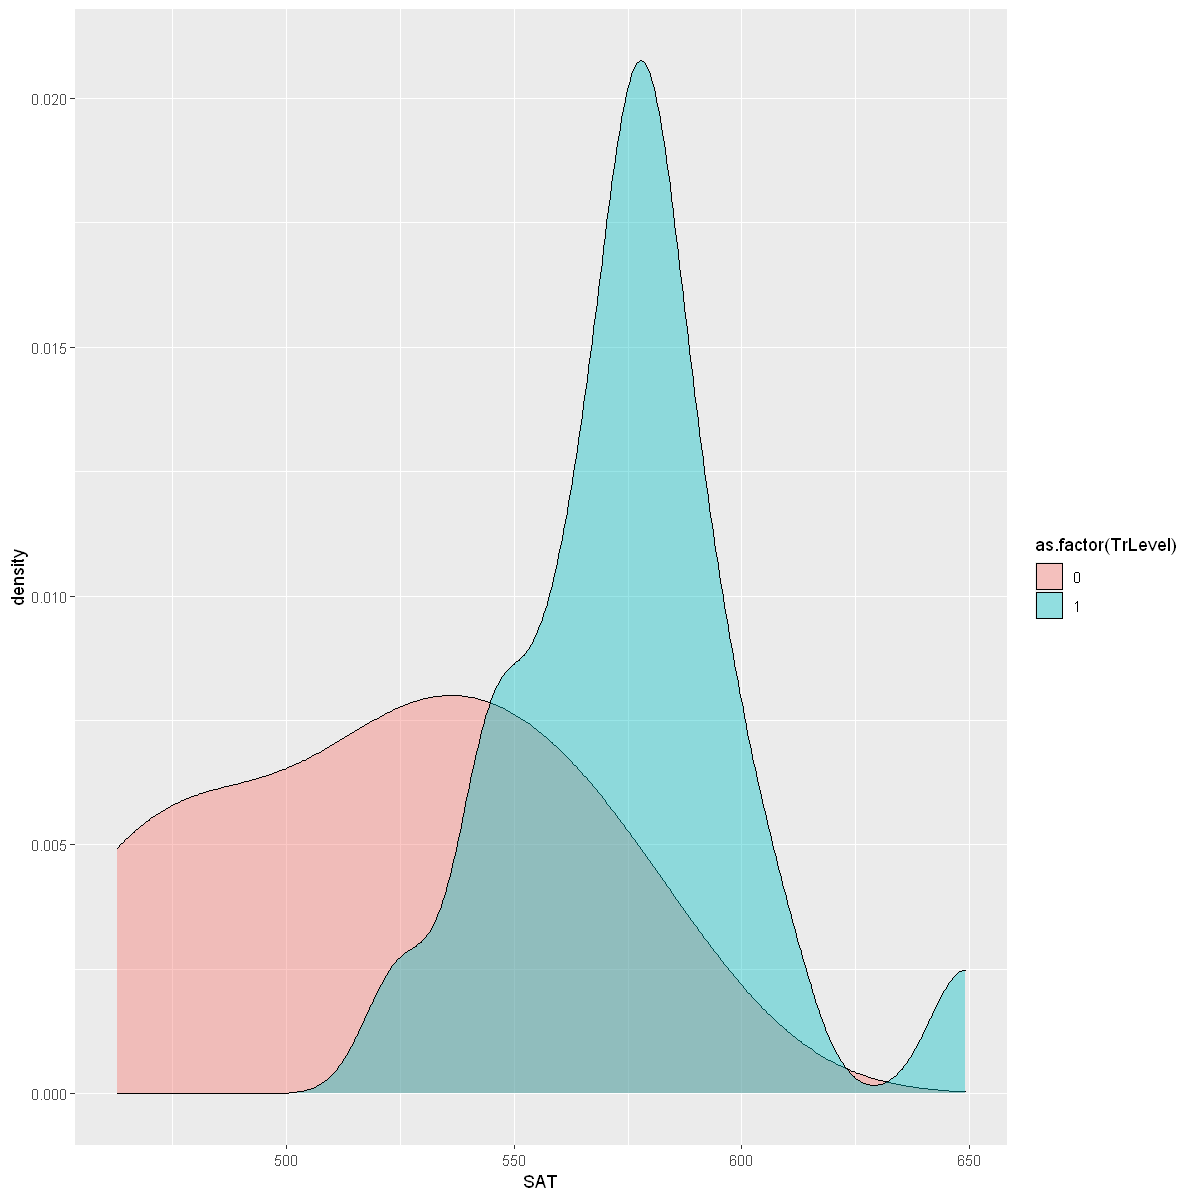

In [3]:
#Ejemplo de regresión logística para datos SAT

datos <- read.csv("datosSAT.csv",header=TRUE,sep=";")
summary(datos)

#TrLevel es el nivel alcanzado: 1 si pasó el curso 0 si no
#SAT es el puntaje obtenido en el test de Lenguaje

ggplot(datos, aes(SAT, fill = as.factor(TrLevel))) +
  geom_density(alpha = .4)


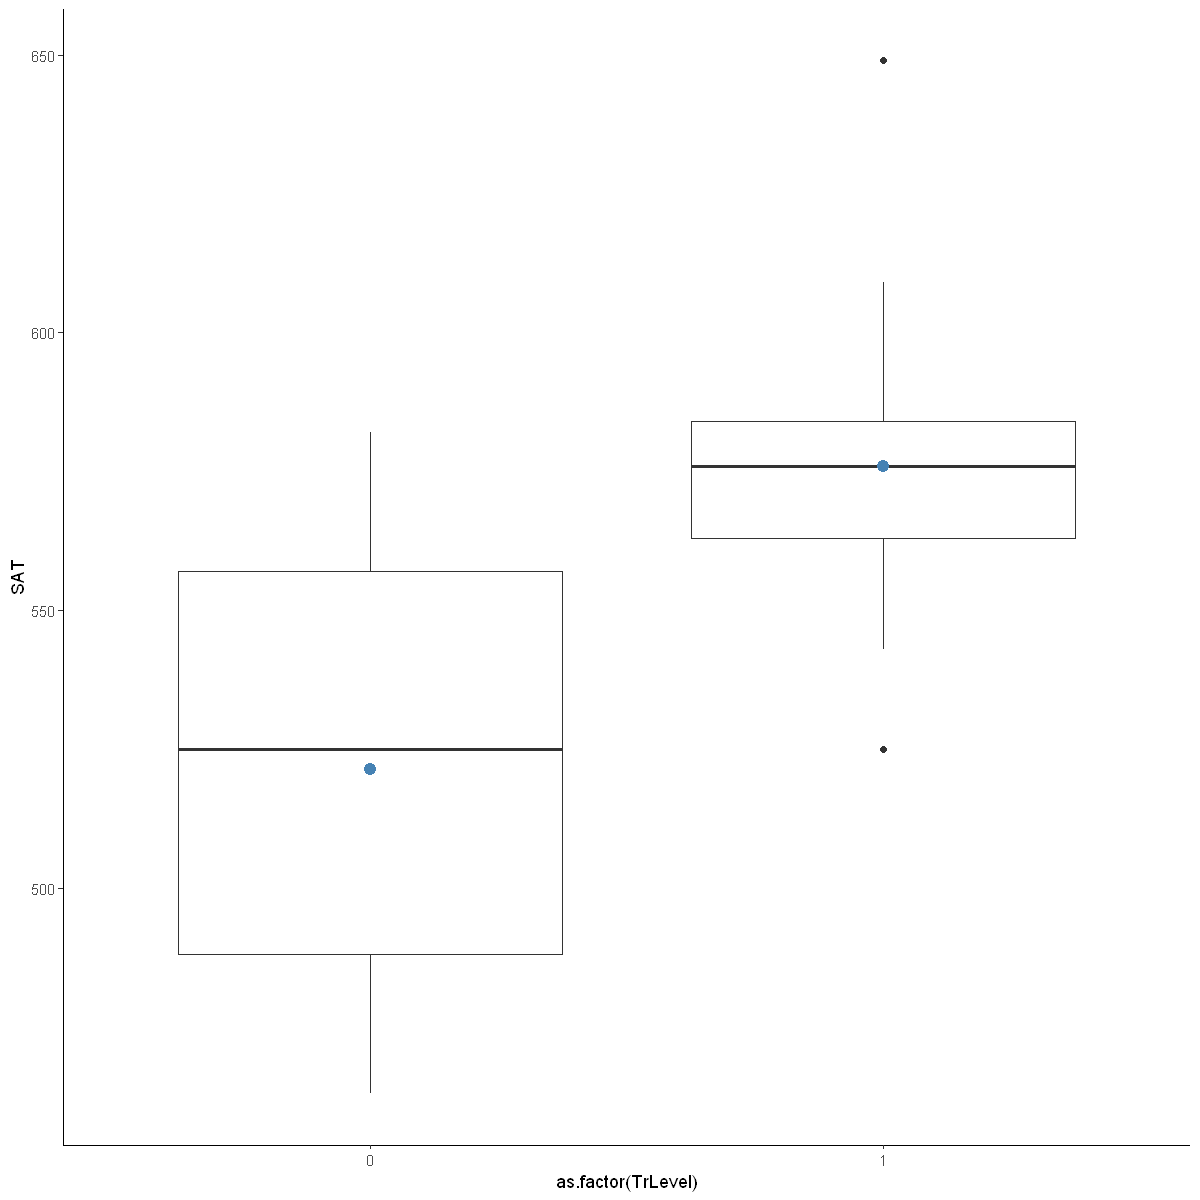

In [4]:
ggplot(datos, aes(x = as.factor(TrLevel), y = SAT)) +
    geom_boxplot() +
    stat_summary(fun = mean,
        geom = "point",
        size = 3,
        color = "steelblue") +
    theme_classic()

In [5]:
res<- glm(TrLevel ~ SAT, data=datos,family = binomial(link = "logit"))
summary(res)


Call:
glm(formula = TrLevel ~ SAT, family = binomial(link = "logit"), 
    data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2918  -0.1830   0.3662   0.5057   1.5301  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -31.65827   12.69071  -2.495   0.0126 *
SAT           0.05878    0.02296   2.560   0.0105 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 36.652  on 29  degrees of freedom
Residual deviance: 21.993  on 28  degrees of freedom
AIC: 25.993

Number of Fisher Scoring iterations: 5


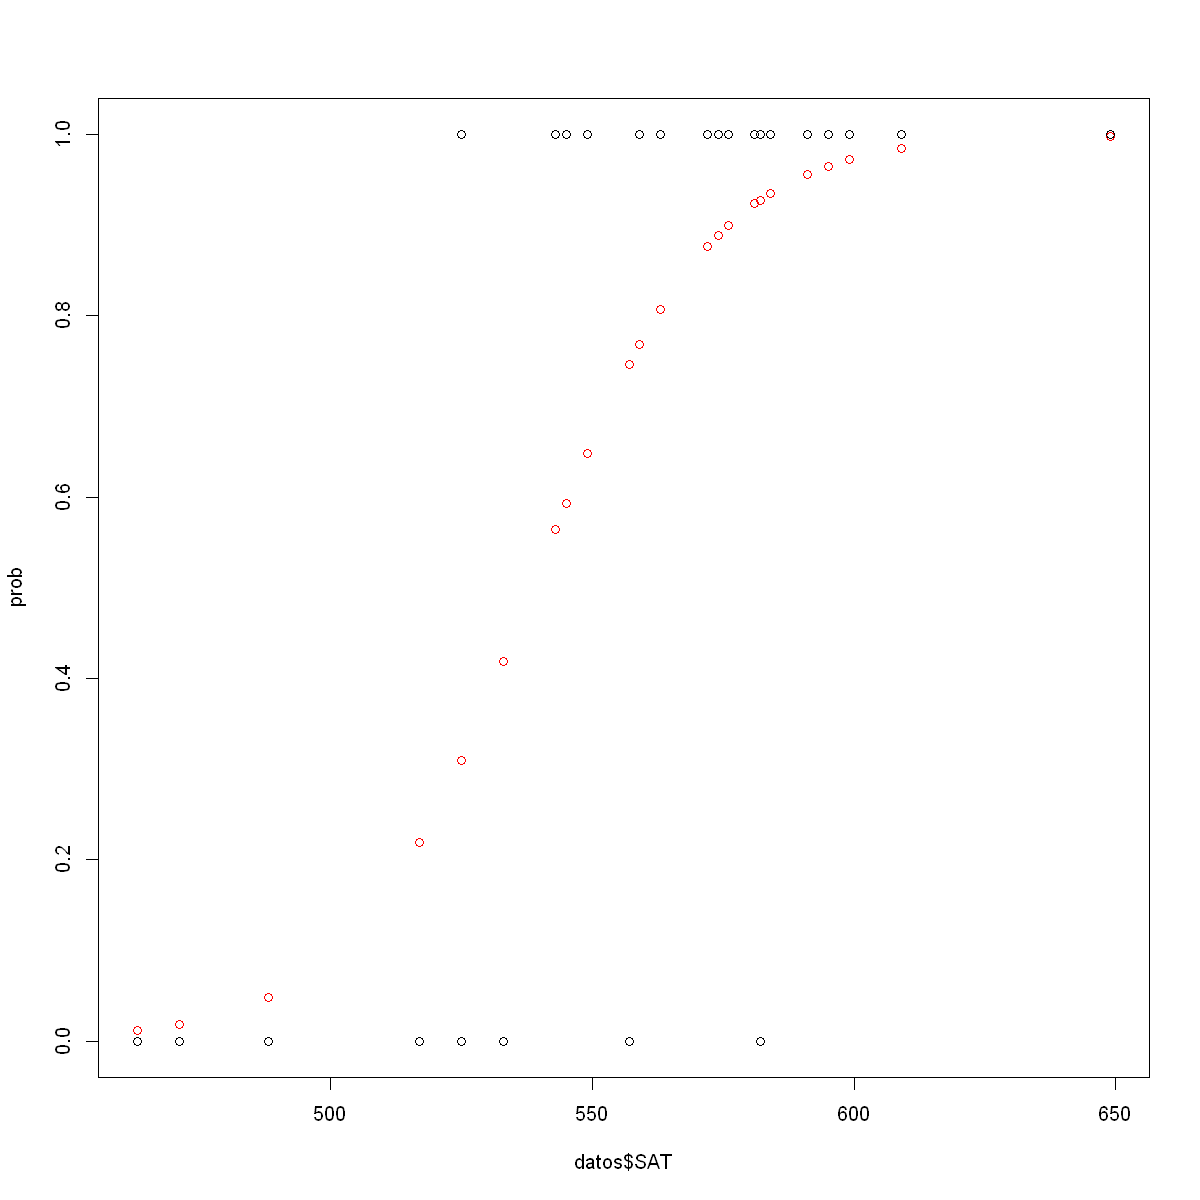

In [6]:
#graficamos los resultados
dat <-cbind(rep(1,30),datos$SAT)
prob <- sigma(dat%*%res$coefficients)
plot(datos$SAT,prob,col="red",ylim=c(0,1))
points(datos$SAT,datos$TrLevel)

### Evaluación del Ajuste del modelo

**Cálculo de residuos**

Si notamos
$$ \hat{p}_i = \sigma(\hat{\beta}^T x_i)$$ 

entonces se define el residuo en la verosimilitud correspondiente a la observación $i$ en el modelo estimado como:

$$dev_i = -2 [y_i log (\hat{p}_i) + (1-y_i) log (1-  \hat{p}_i)]$$

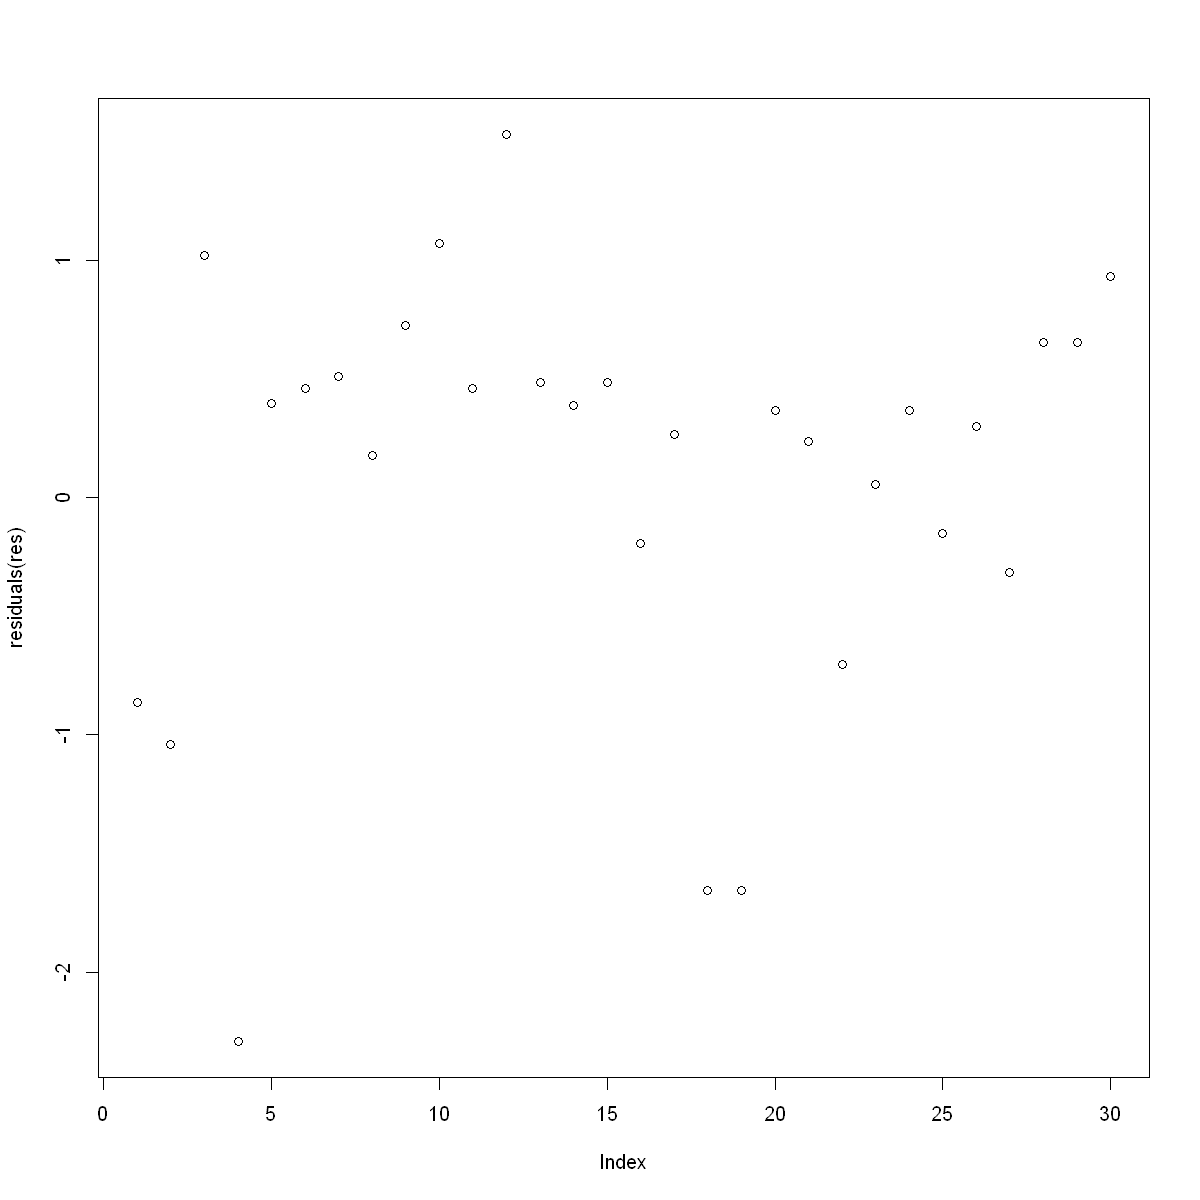

In [7]:
plot(residuals(res))

**Coeficiente de información de Akaike, AIC**

Recordemos que 

$$AIC = 2k - 2logL$$

donde k es el número de parámetros del modelo. Cuando se comparan modelos se escoge aquel con menor AIC.

**Error de clasificación: Matriz de confusión**

La matriz de confusión permite analizar los errores de clasificación:
- Error tipo I o "falso positivo": caso predicho con valor 1, cuando se observa 0
- Error tipo II o "falso negativo": caso predicho con valor 0 cuando se observa 1

In [8]:
tab <- table(prob>0.5, as.factor(datos$TrLevel))
print(tab)
error <- (tab[2,1]+tab[1,2])/sum(tab)
errorI <- tab[2,1]/(tab[2,1]+tab[2,2])
errorII <- tab[1,2]/(tab[1,1]+tab[1,2])
print(c(errorI,errorII, error))

       
         0  1
  FALSE  6  1
  TRUE   3 20
[1] 0.1304348 0.1428571 0.1333333


**Cuantificando Habilidad Predictiva: Curva ROC**

Este análisis considera variar el valor p(=0.5 por omisión) que guía la clasificación de los datos y se observa como varían la sensibilidad (tasa de verdaderos positivos sobre el total de positivos)  en relación al inverso de la especificidad (tasa de verdaderos negativos sobre el total de negativos). Si el área bajo la curva ROC es cercana a 1 se trata de un buen clasificador, si es cercana a 0.5 corresponde a una clasificación aleatoria (igual probabilidad de positivo o negativo).

In [9]:
min(prob)

[1] 0.01161768

            [,1]      [,2]      [,3]
 [1,] 0.01161768 1.0000000 0.1111111
 [2,] 0.06161768 1.0000000 0.3333333
 [3,] 0.11161768 1.0000000 0.3333333
 [4,] 0.16161768 1.0000000 0.3333333
 [5,] 0.21161768 1.0000000 0.3333333
 [6,] 0.26161768 1.0000000 0.4444444
 [7,] 0.31161768 0.9523810 0.5555556
 [8,] 0.36161768 0.9523810 0.5555556
 [9,] 0.41161768 0.9523810 0.5555556
[10,] 0.46161768 0.9523810 0.6666667
[11,] 0.51161768 0.9523810 0.6666667
[12,] 0.56161768 0.9523810 0.6666667
[13,] 0.61161768 0.8571429 0.6666667
[14,] 0.66161768 0.8095238 0.6666667
[15,] 0.71161768 0.8095238 0.6666667
[16,] 0.76161768 0.8095238 0.8888889
[17,] 0.81161768 0.6666667 0.8888889
[18,] 0.86161768 0.6666667 0.8888889
[19,] 0.91161768 0.4285714 0.8888889


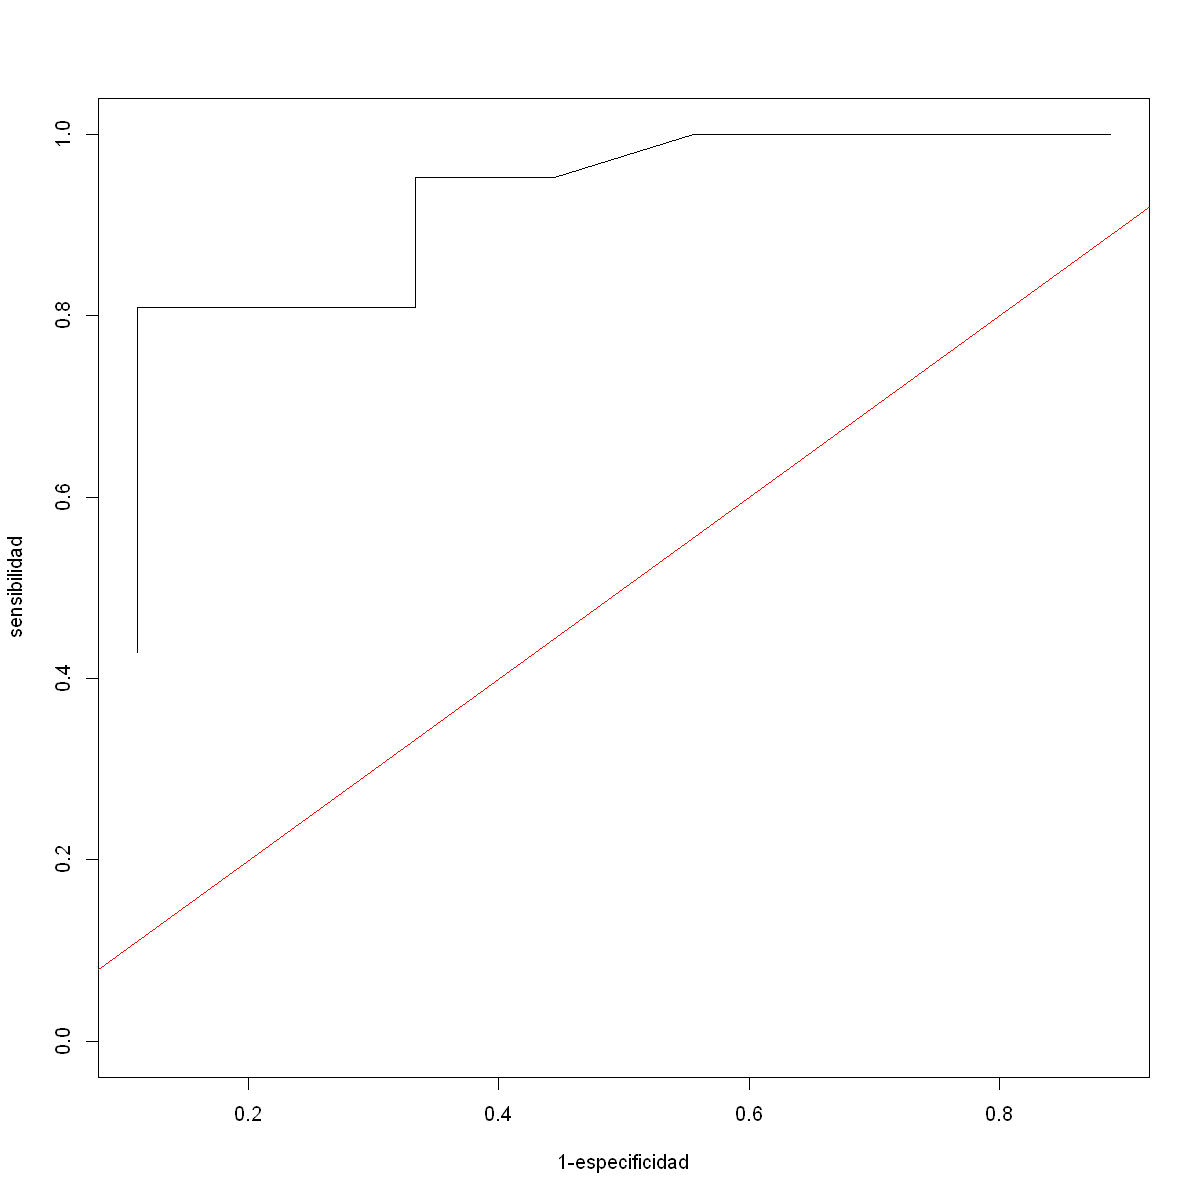

In [10]:
p1=matrix(0,nrow=19,ncol=3)
i=1
for(p in seq(min(prob),.95,.05)){
    t1=table(prob>p,as.factor(datos$TrLevel))
    p1[i,]=c(p,(t1[2,2])/sum(t1[,2]),(t1[1,1])/sum(t1[,1]))
    i=i+1
}
print(p1)
plot(1-p1[,3],p1[,2],type="l",xlab="1-especificidad",ylab="sensibilidad",ylim=c(0,1))
lines(c(0,1),c(0,1),col="red")

In [11]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [12]:
#Ejemplo de regresión logística para datos de PSU de estudiantes de primer año universitario
#y su relación con la estrategia de aprendizaje Elaborativa del estudiante (0, bajo nivel - 1 normal o alto nivel)
#obtenida en un test de diagnóstico
datos <- read.csv("datosEjemplo.csv",header=TRUE,sep=";")
print(datos[1:10,])
summary(datos)


   Elaborativo MAT LENG CIENCIA
1            0 429  573     443
2            0 572  534     497
3            1 631  692     611
4            0 713  654     694
5            1 591  523     537
6            0 610  530     558
7            1 619  628     409
8            0 596  628     625
9            1 644  466     523
10           0 644  628     591


  Elaborativo          MAT             LENG          CIENCIA     
 Min.   :0.0000   Min.   :429.0   Min.   :442.0   Min.   :371.0  
 1st Qu.:0.0000   1st Qu.:581.0   1st Qu.:530.0   1st Qu.:523.0  
 Median :1.0000   Median :605.0   Median :573.0   Median :570.0  
 Mean   :0.6796   Mean   :603.8   Mean   :576.9   Mean   :560.7  
 3rd Qu.:1.0000   3rd Qu.:636.0   3rd Qu.:620.0   3rd Qu.:606.0  
 Max.   :1.0000   Max.   :725.0   Max.   :716.0   Max.   :694.0  

In [13]:
dim(datos)

[1] 103   4

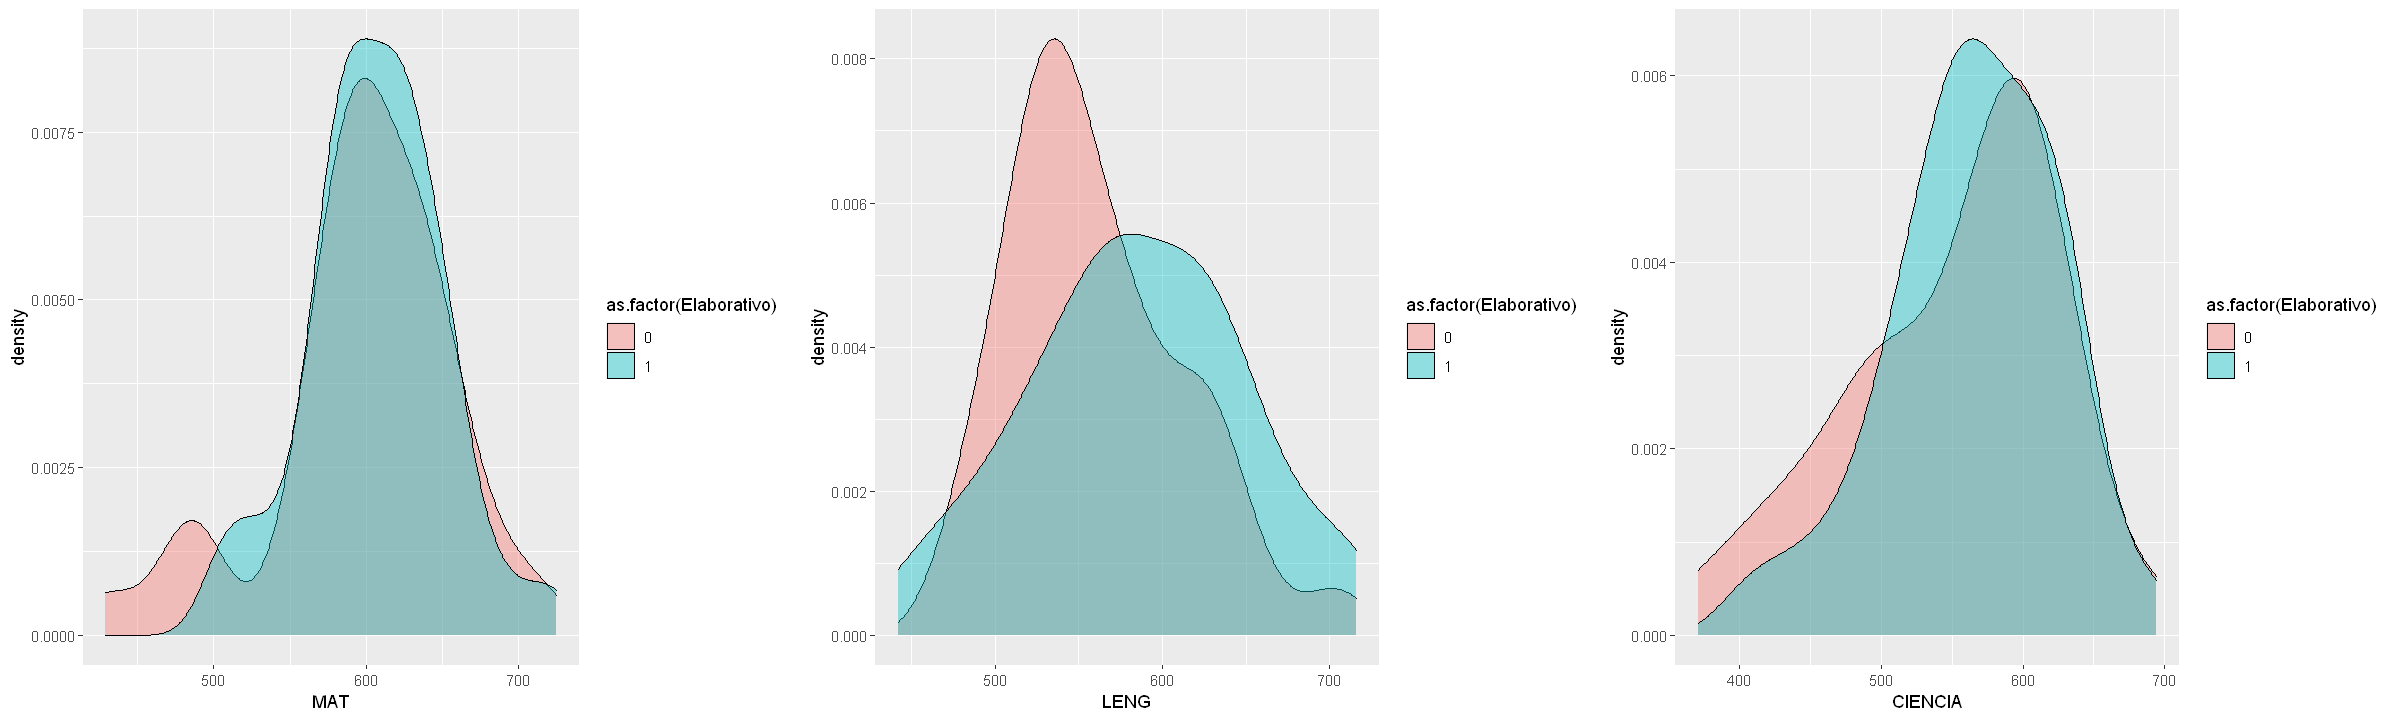

In [14]:
options(repr.plot.width=20, repr.plot.height=6)
f1 <- ggplot(datos, aes(MAT, fill = as.factor(Elaborativo))) +
  geom_density(alpha = .4)
f2 <- ggplot(datos, aes(LENG, fill = as.factor(Elaborativo))) +
  geom_density(alpha = .4)
f3 <- ggplot(datos, aes(CIENCIA, fill = as.factor(Elaborativo))) +
  geom_density(alpha = .4)
  
multiplot(f1,f2,f3, cols=3)

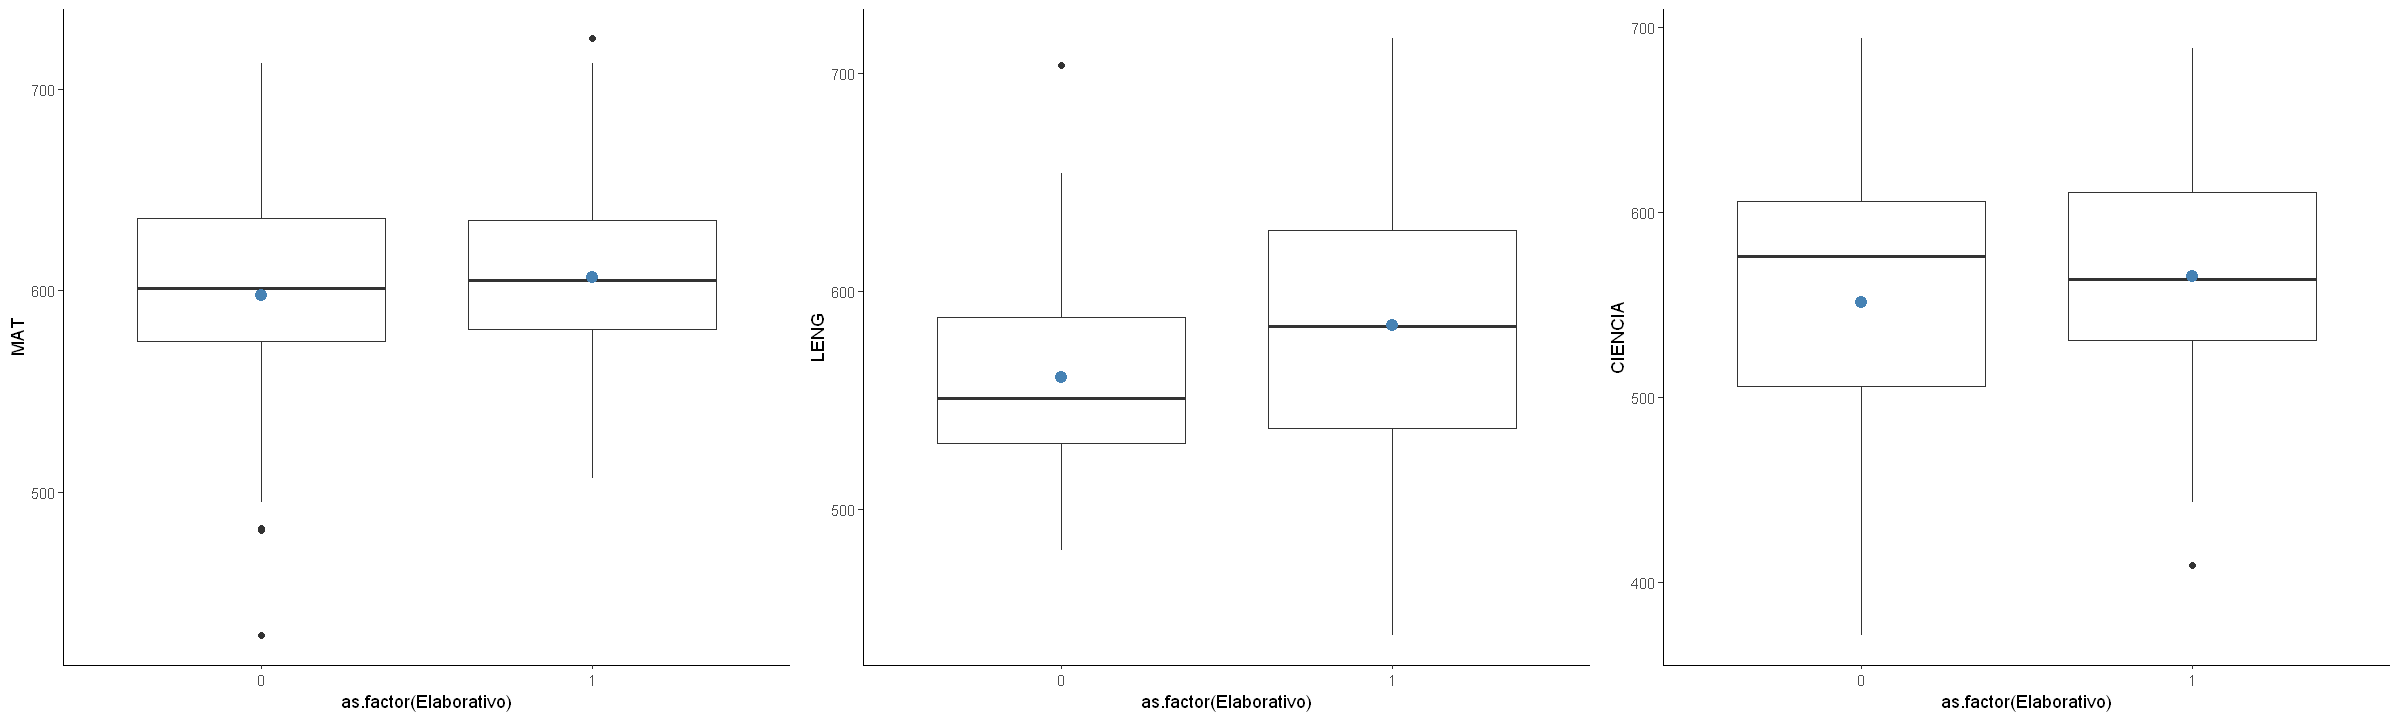

In [15]:
f1 <- ggplot(datos, aes(x = as.factor(Elaborativo), y = MAT)) +
    geom_boxplot() +
    stat_summary(fun = mean,
        geom = "point",
        size = 3,
        color = "steelblue") +
    theme_classic()

f2<- ggplot(datos, aes(x = as.factor(Elaborativo), y = LENG)) +
    geom_boxplot() +
    stat_summary(fun = mean,
        geom = "point",
        size = 3,
        color = "steelblue") +
    theme_classic()
    
f3 <- ggplot(datos, aes(x = as.factor(Elaborativo), y = CIENCIA)) +
    geom_boxplot() +
    stat_summary(fun = mean,
        geom = "point",
        size = 3,
        color = "steelblue") +
    theme_classic()

multiplot(f1,f2,f3, cols=3)

In [16]:
## análisis con las 3 variables
res0<- glm(Elaborativo ~ MAT+LENG+CIENCIA, data=datos,family = binomial(link = "logit"))
summary(res0)


Call:
glm(formula = Elaborativo ~ MAT + LENG + CIENCIA, family = binomial(link = "logit"), 
    data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9029  -1.3534   0.7578   0.8999   1.1856  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept) -3.4698760  2.8740756  -1.207    0.227
MAT          0.0009539  0.0055064   0.173    0.862
LENG         0.0062689  0.0041219   1.521    0.128
CIENCIA      0.0001063  0.0045875   0.023    0.982

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 129.20  on 102  degrees of freedom
Residual deviance: 125.65  on  99  degrees of freedom
AIC: 133.65

Number of Fisher Scoring iterations: 4


In [17]:
print(res0$coefficients)

  (Intercept)           MAT          LENG       CIENCIA 
-3.4698760404  0.0009539276  0.0062689095  0.0001062675 


In [18]:
dat <-cbind(rep(1,103),datos$MAT,datos$LENG,datos$CIENCIA)
vec <- res0$coefficients
prob0 <- sigma(dat%*%vec)
tab <- table(prob0>0.5, as.factor(datos$Elaborativo))
print(tab)
error <- (tab[2,1]+tab[1,2])/sum(tab)
errorI <- tab[2,1]/(tab[2,1]+tab[2,2])
errorII <- tab[1,2]/(tab[1,1]+tab[1,2])
print(c(errorI,errorII, error))

       
         0  1
  FALSE  0  3
  TRUE  33 67
[1] 0.3300000 1.0000000 0.3495146


          [,1]       [,2]       [,3]
[1,] 0.4952148 0.98571429 0.00000000
[2,] 0.5452148 0.90000000 0.06060606
[3,] 0.5952148 0.87142857 0.21212121
[4,] 0.6452148 0.70000000 0.54545455
[5,] 0.6952148 0.51428571 0.69696970
[6,] 0.7452148 0.30000000 0.81818182
[7,] 0.7952148 0.10000000 0.93939394
[8,] 0.8452148 0.02857143 1.00000000


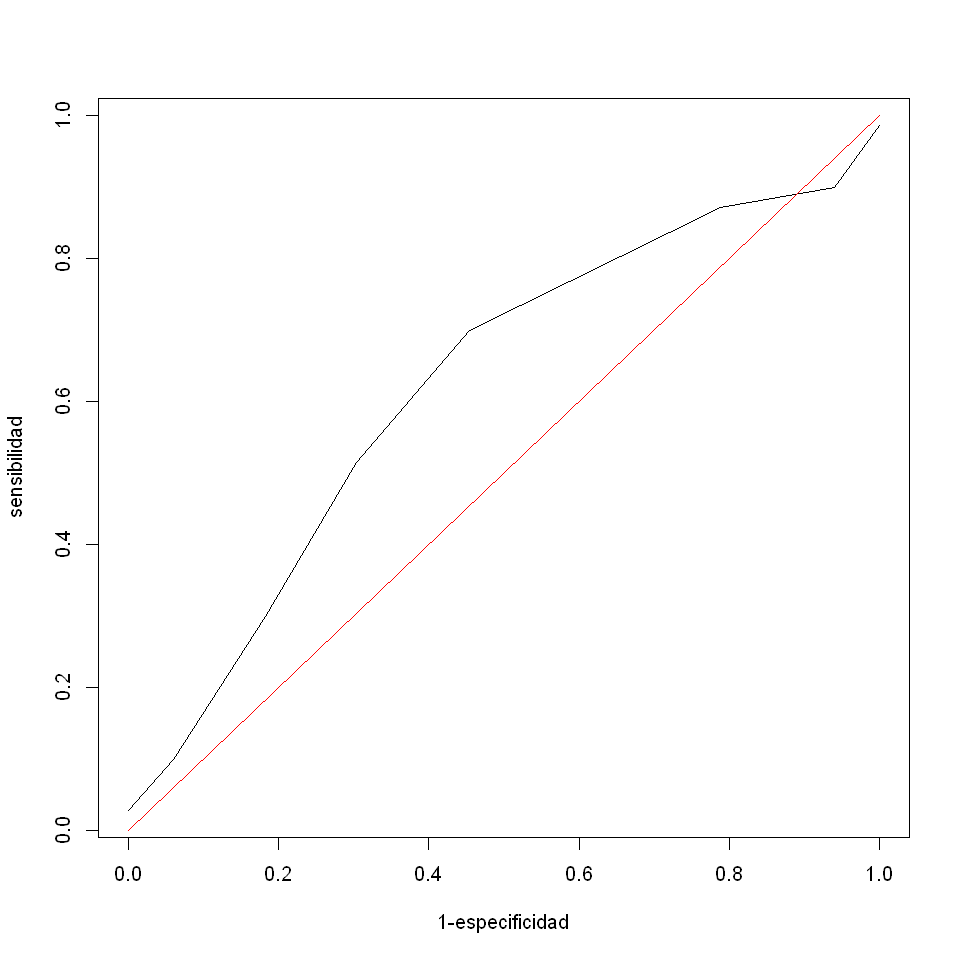

In [29]:
options(repr.plot.width=8, repr.plot.height=8)
p0=matrix(0,nrow=8,ncol=3)
i=1
for(p in seq(min(prob0),.85,.05)){
    t1=table(prob0>p,as.factor(datos$Elaborativo))
    p0[i,]=c(p,(t1[2,2])/sum(t1[,2]),(t1[1,1])/sum(t1[,1]))
    i=i+1
}
print(p0)
plot(1-p0[,3],p0[,2],type="l",xlab="1-especificidad",ylab="sensibilidad")
lines(c(0,1),c(0,1),col="red")

In [19]:
## análisis con 2 variables
res1<- glm(Elaborativo ~ MAT+LENG, data=datos,family = binomial(link = "logit"))
summary(res1)


Call:
glm(formula = Elaborativo ~ MAT + LENG, family = binomial(link = "logit"), 
    data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9033  -1.3510   0.7515   0.8978   1.1853  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -3.473364   2.870078  -1.210    0.226
MAT          0.001026   0.004539   0.226    0.821
LENG         0.006303   0.003856   1.635    0.102

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 129.20  on 102  degrees of freedom
Residual deviance: 125.65  on 100  degrees of freedom
AIC: 131.65

Number of Fisher Scoring iterations: 4


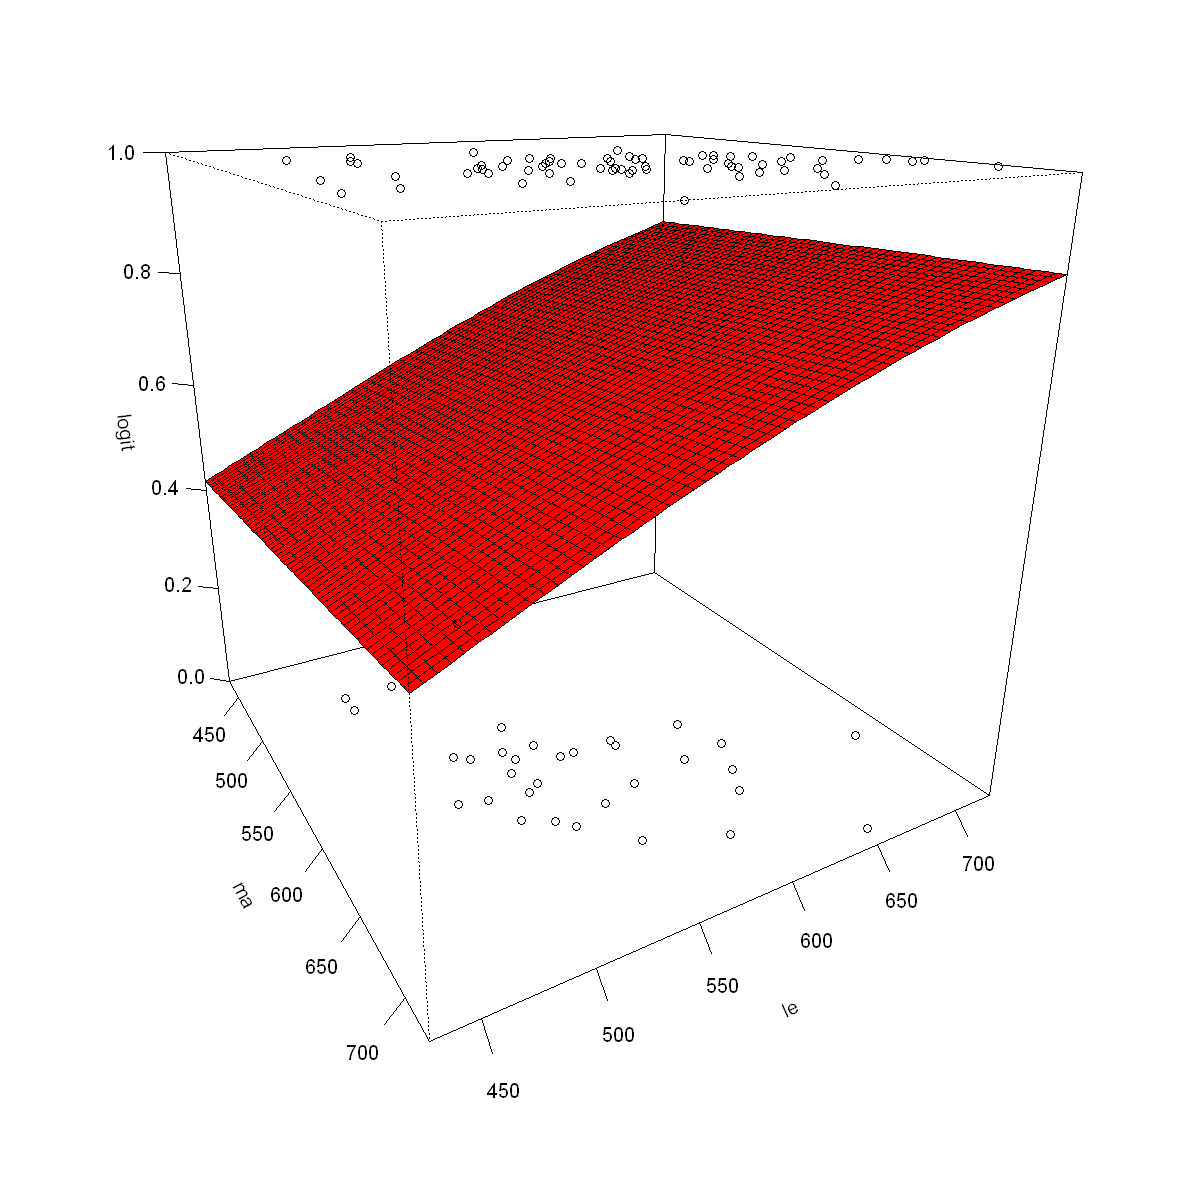

In [20]:
#graficamos los resultados
options(repr.plot.width=10, repr.plot.height=10)

ma <- seq(429,726,by=5)
le <- seq(429,726,by=5)

dens <- function(x,y) sigma(res1$coefficients[1] + x*res1$coefficients[2] + y*res1$coefficients[3] )
z <- outer(ma,le,dens)
pmat<- persp(ma,le,z,ticktype = "detailed",zlab="logit",zlim=c(0,1), phi=20,theta=60,col="red")
points(trans3d(datos$MAT,datos$LENG,datos$Elaborativo,pmat=pmat))

In [22]:
dat <-cbind(rep(1,103),datos$MAT,datos$LENG)
prob1 <- sigma(dat%*%res1$coefficients)
tab <- table(prob1>0.5, as.factor(datos$Elaborativo))
print(tab)
error <- (tab[2,1]+tab[1,2])/sum(tab)
errorI <- tab[2,1]/(tab[2,1]+tab[2,2])
errorII <- tab[1,2]/(tab[1,1]+tab[1,2])
print(c(errorI,errorII, error))

       
         0  1
  FALSE  0  3
  TRUE  33 67
[1] 0.3300000 1.0000000 0.3495146


          [,1]       [,2]       [,3]
[1,] 0.4953638 0.98571429 0.00000000
[2,] 0.5453638 0.88571429 0.06060606
[3,] 0.5953638 0.87142857 0.21212121
[4,] 0.6453638 0.71428571 0.54545455
[5,] 0.6953638 0.51428571 0.69696970
[6,] 0.7453638 0.30000000 0.81818182
[7,] 0.7953638 0.10000000 0.93939394
[8,] 0.8453638 0.02857143 1.00000000


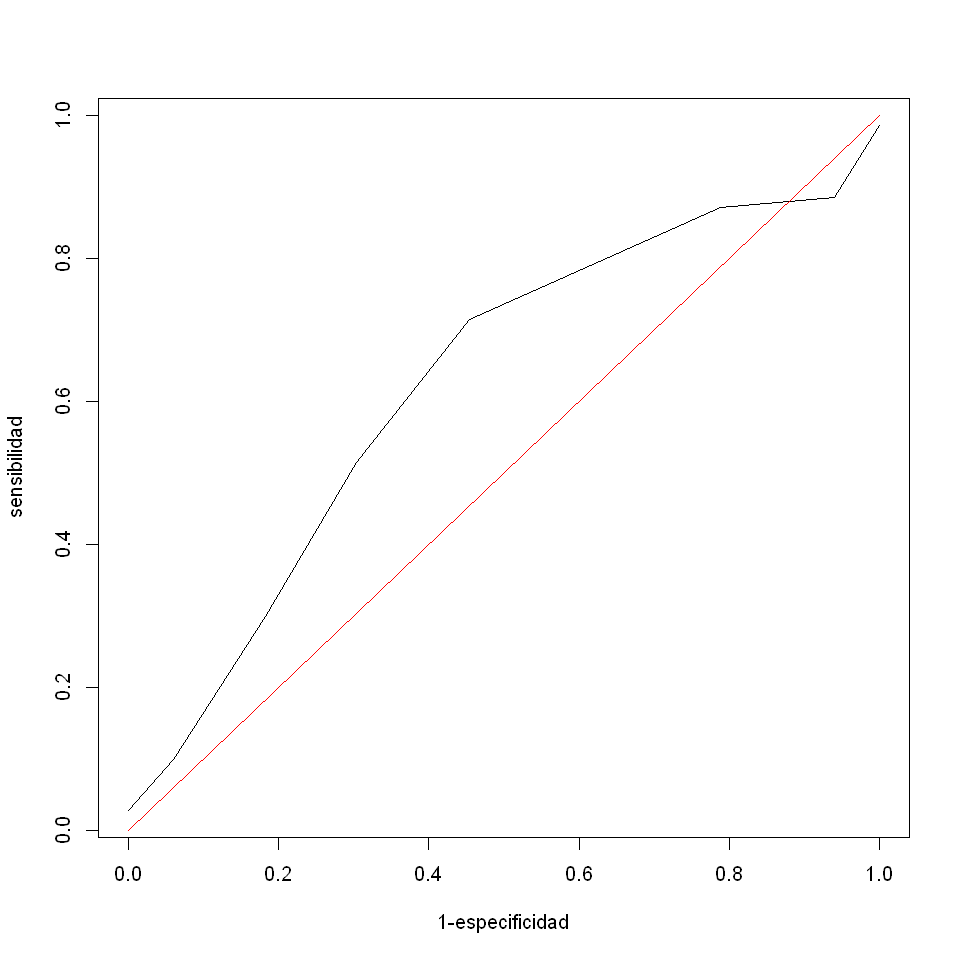

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
p1=matrix(0,nrow=8,ncol=3)
i=1
for(p in seq(min(prob1),.85,.05)){
    t1=table(prob1>p,as.factor(datos$Elaborativo))
    p1[i,]=c(p,(t1[2,2])/sum(t1[,2]),(t1[1,1])/sum(t1[,1]))
    i=i+1
}
print(p1)
plot(1-p1[,3],p1[,2],type="l",xlab="1-especificidad",ylab="sensibilidad")
lines(c(0,1),c(0,1),col="red")

In [24]:
res2<- glm(Elaborativo ~ LENG, data=datos,family = binomial(link = "logit"))
summary(res2)


Call:
glm(formula = Elaborativo ~ LENG, family = binomial(link = "logit"), 
    data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8979  -1.3454   0.7518   0.8943   1.2238  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -3.025041   2.071847  -1.460   0.1443  
LENG         0.006599   0.003628   1.819   0.0689 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 129.2  on 102  degrees of freedom
Residual deviance: 125.7  on 101  degrees of freedom
AIC: 129.7

Number of Fisher Scoring iterations: 4


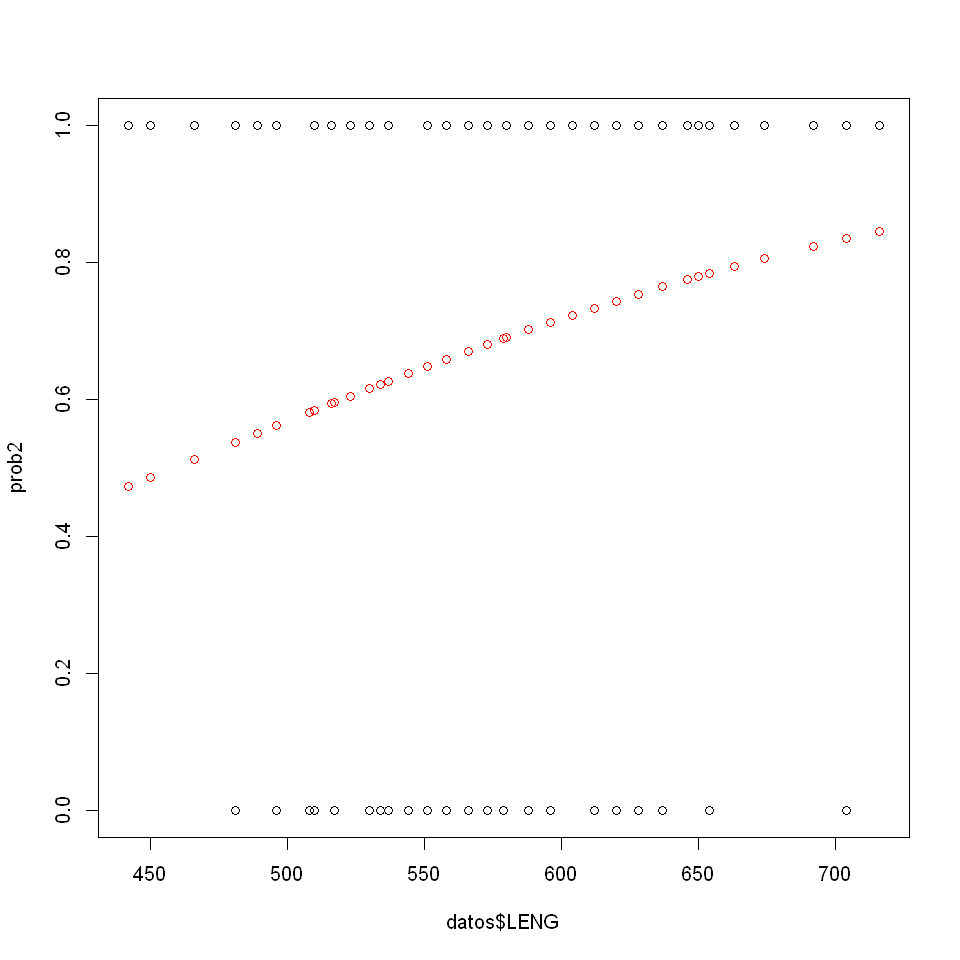

In [25]:
#graficamos los resultados
dat <-cbind(rep(1,103),datos$LENG)
prob2 <- sigma(dat%*%res2$coefficients)
plot(datos$LENG,prob2,col="red",ylim=c(0,1))
points(datos$LENG,datos$Elaborativo)

In [26]:
tab <- table(prob2>0.5, as.factor(datos$Elaborativo))
print(tab)
error <- (tab[2,1]+tab[1,2])/sum(tab)
errorI <- tab[2,1]/(tab[2,1]+tab[2,2])
errorII <- tab[1,2]/(tab[1,1]+tab[1,2])
print(c(errorI,errorII, error))

       
         0  1
  FALSE  0  2
  TRUE  33 68
[1] 0.3267327 1.0000000 0.3398058


In [ ]:
print(min(prob2))

          [,1]       [,2]       [,3]
[1,] 0.4729352 0.98571429 0.00000000
[2,] 0.5229352 0.94285714 0.00000000
[3,] 0.5729352 0.88571429 0.09090909
[4,] 0.6229352 0.77142857 0.36363636
[5,] 0.6729352 0.58571429 0.63636364
[6,] 0.7229352 0.42857143 0.78787879
[7,] 0.7729352 0.18571429 0.93939394
[8,] 0.8229352 0.07142857 0.96969697


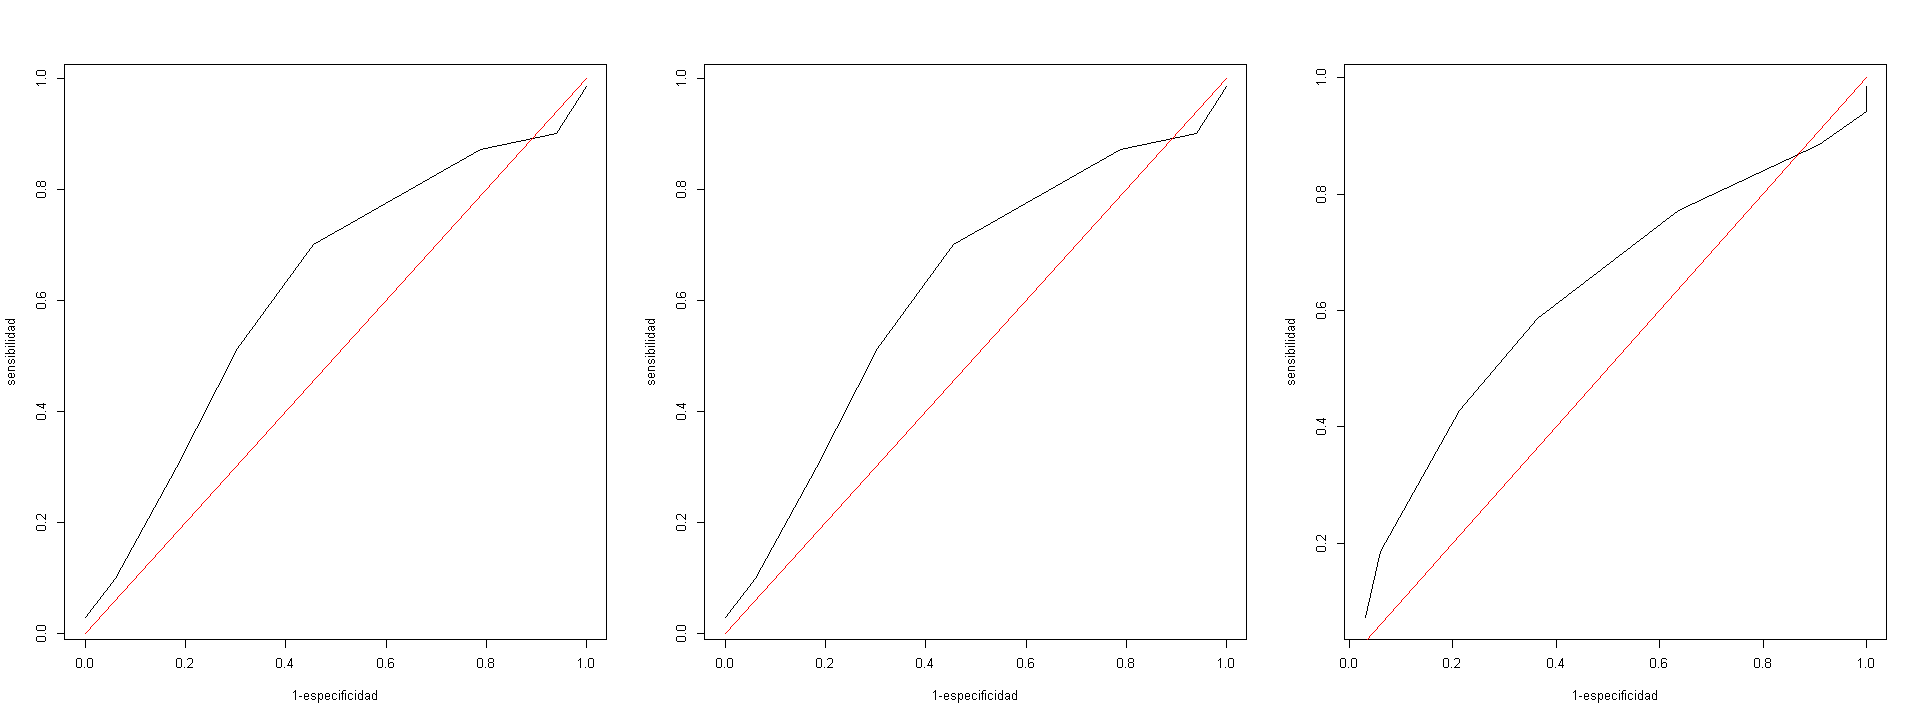

In [31]:
options(repr.plot.width=16, repr.plot.height=6)
p2=matrix(0,nrow=8,ncol=3)
i=1
for(p in seq(min(prob2),.85,.05)){
    t2=table(prob2>p,as.factor(datos$Elaborativo))
    p2[i,]=c(p,(t2[2,2])/sum(t2[,2]),(t2[1,1])/sum(t2[,1]))
    i=i+1
}
print(p2)

par(mfrow=c(1,3))

plot(1-p0[,3],p0[,2],type="l",xlab="1-especificidad",ylab="sensibilidad")
lines(c(0,1),c(0,1),col="red")

plot(1-p1[,3],p1[,2],type="l",xlab="1-especificidad",ylab="sensibilidad")
lines(c(0,1),c(0,1),col="red")

plot(1-p2[,3],p2[,2],type="l",xlab="1-especificidad",ylab="sensibilidad")
lines(c(0,1),c(0,1),col="red")



## Regresión de Poisson
En este caso la variable a explicar es **discreta**, mas precisamente es una variable de conteo o a valores en $\it N$  y las variables explicativas son numéricas o categóricas. 

**Formalmente:**

Sea $y \in \{0,1,2, \cdots\}$ la variable a explicar y $\textbf{x} \in \mathbb{R}^k$ las variables explicativas.
 

Entonces $y\mid \textbf{x}$ se modela como una v.a. con distribución $\textbf{Poisson}$, es decir:

$$p(y |\textbf{x},\beta)= Poisson(\lambda(\textbf{x},\beta))$$

dónde, al igual que en la regresión lineal, se considera una combinación lineal de las variables explicativas, pero esta combinación lineal es pasada como parámetro a una función $ \lambda$ que toma valores positivos:

$$\lambda(\textbf{x},\beta) = \lambda_{\textbf{x},\beta}=e^{\beta^T\textbf{x}}$$

Así, 

$$p(y |\textbf{x},\beta) = p(y | \lambda_{\textbf{x},\beta}) = \frac{\lambda_{\textbf{x},\beta}^{y}}{y!} \exp \left ({-\lambda_{\textbf{x},\beta}} \right) = 
\frac{e^{y \beta^T\textbf{x}}}{y!} \exp \left (-e^{\beta^T\textbf{x}} \right)$$



Notar que en este caso, se tiene:

$$\log E(Y \mid \textbf{x}) = \log \lambda_{\textbf{x},\beta} = \beta^T \textbf{x}$$


### Estimación de parámetros $\beta$
Los parámetros $\beta$ se pueden estimar por máxima verosimilitud.
En efecto, sea la muestra $\{(y_i,\textbf{x}_i), i=1,\cdots,n\}$, se tiene:

$$\log \mathcal{L} (\beta) =   {\displaystyle \sum_{i=1}^n}\left (y_i \beta^T \textbf{x}_i -  e^{\beta^T \textbf{x}_i} - \log(y_i!)\right)$$

A partir de esta función de verosimilitud no es posible obtener de manera analítica los  estimadores máximo verosímiles de $\beta$. Utilizando Newton-Raphson para aproximar las raices del gradiente de $\log \mathcal{L}(\beta)$ se obtiene:

$$\hat{\beta}^{nuevo} = \hat{\beta}^{viejo} + (X^TW X)^{-1}X^T(\textbf{y} - \hat{\lambda})$$

donde $X \in M_{nxk}$ es la matriz de valores de las $k$ variables explicativas en las $n$ observaciones, 

$$\hat{\lambda}_i = e^{X_{i}\beta^{viejo}}$$

y $W \in M_{nxn}$ es la matriz diagonal con:

$$ w_{ii} = \hat{\lambda}_i$$

Lo criterios de convergencia del método iterativo utilizado para estimar los parámetros pueden ser varios, pero en todos ellos la idea subyacente es que 

$$\hat{\beta}^{nuevo} \approx \hat{\beta}^{viejo} \qquad \mbox{o} \qquad \log \mathcal{L}(\hat{\beta}^{viejo}) \approx log \mathcal{L} (\hat{\beta}^{nuevo})\qquad \mbox{o} \qquad \hat{\lambda}^{viejo} \approx \hat{\lambda}^{nuevo}$$


In [38]:
#ejemplo de regresión de Poisson que considera datos simulados sobre 200 estudiantes de EM
#la variable a explicar es el número de premios obtenidos y las variables explicativas
#son sus puntajes en el examen final de matemáticas, y el tipo de programa en que 
#están matriculados: general, vocacional o académico.
require(ggplot2)
options(repr.plot.width=10, repr.plot.height=10)
p <- read.csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")
p <- within(p, {
  prog <- factor(prog, levels=1:3, labels=c("General", "Academic", 
                                                     "Vocational"))
  id <- factor(id)
})
print(p[1:20,])
summary(p)

    id num_awards       prog math
1   45          0 Vocational   41
2  108          0    General   41
3   15          0 Vocational   44
4   67          0 Vocational   42
5  153          0 Vocational   40
6   51          0    General   42
7  164          0 Vocational   46
8  133          0 Vocational   40
9    2          0 Vocational   33
10  53          0 Vocational   46
11   1          0 Vocational   40
12 128          0   Academic   38
13  16          0 Vocational   44
14 106          0 Vocational   37
15  89          0 Vocational   40
16 134          0    General   39
17  19          0    General   43
18 145          0 Vocational   38
19  11          0   Academic   45
20 117          0 Vocational   39


       id        num_awards           prog          math      
 1      :  1   Min.   :0.00   General   : 45   Min.   :33.00  
 2      :  1   1st Qu.:0.00   Academic  :105   1st Qu.:45.00  
 3      :  1   Median :0.00   Vocational: 50   Median :52.00  
 4      :  1   Mean   :0.63                    Mean   :52.65  
 5      :  1   3rd Qu.:1.00                    3rd Qu.:59.00  
 6      :  1   Max.   :6.00                    Max.   :75.00  
 (Other):194                                                  

In [33]:
with(p, tapply(num_awards, prog, function(x) {
  sprintf("M (SD) = %1.2f (%1.2f)", mean(x), sd(x))
}))

General               Academic             Vocational 
"M (SD) = 0.20 (0.40)" "M (SD) = 1.00 (1.28)" "M (SD) = 0.24 (0.52)"

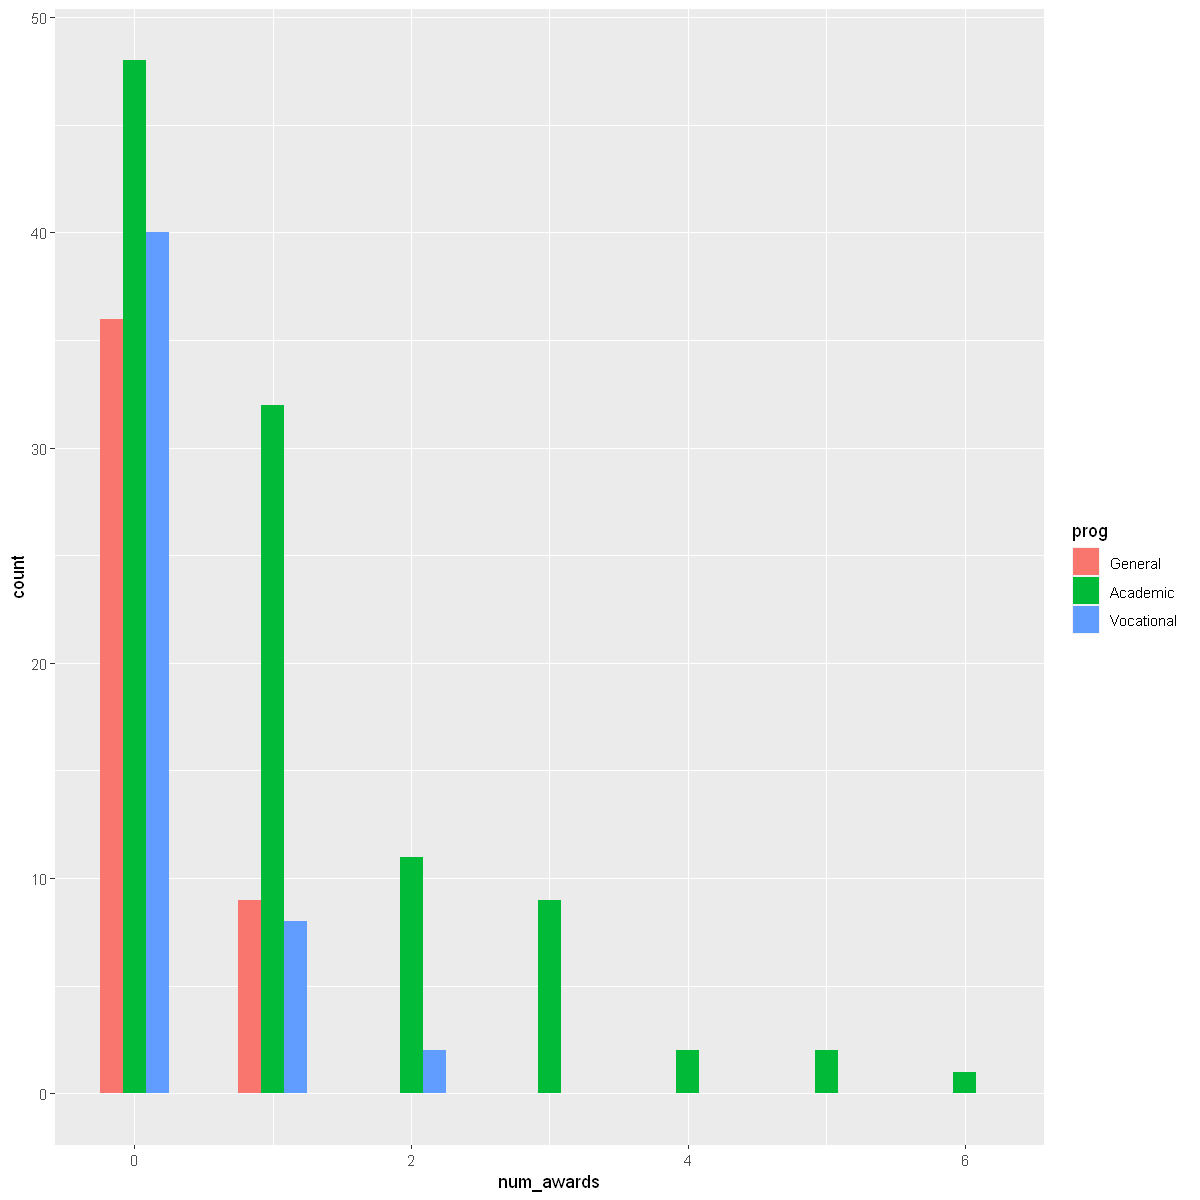

In [39]:
ggplot(p, aes(num_awards, fill = prog)) +
  geom_histogram(binwidth=.5, position="dodge")

In [40]:
summary(m1 <- glm(num_awards ~ prog + math, family="poisson", data=p))


Call:
glm(formula = num_awards ~ prog + math, family = "poisson", data = p)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2043  -0.8436  -0.5106   0.2558   2.6796  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.24712    0.65845  -7.969 1.60e-15 ***
progAcademic    1.08386    0.35825   3.025  0.00248 ** 
progVocational  0.36981    0.44107   0.838  0.40179    
math            0.07015    0.01060   6.619 3.63e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 287.67  on 199  degrees of freedom
Residual deviance: 189.45  on 196  degrees of freedom
AIC: 373.5

Number of Fisher Scoring iterations: 6


In [41]:
with(m1, cbind(res.deviance = deviance, df = df.residual,
  p = pchisq(deviance, df.residual, lower.tail=FALSE)))

res.deviance,df,p
189.4496,196,0.6182274


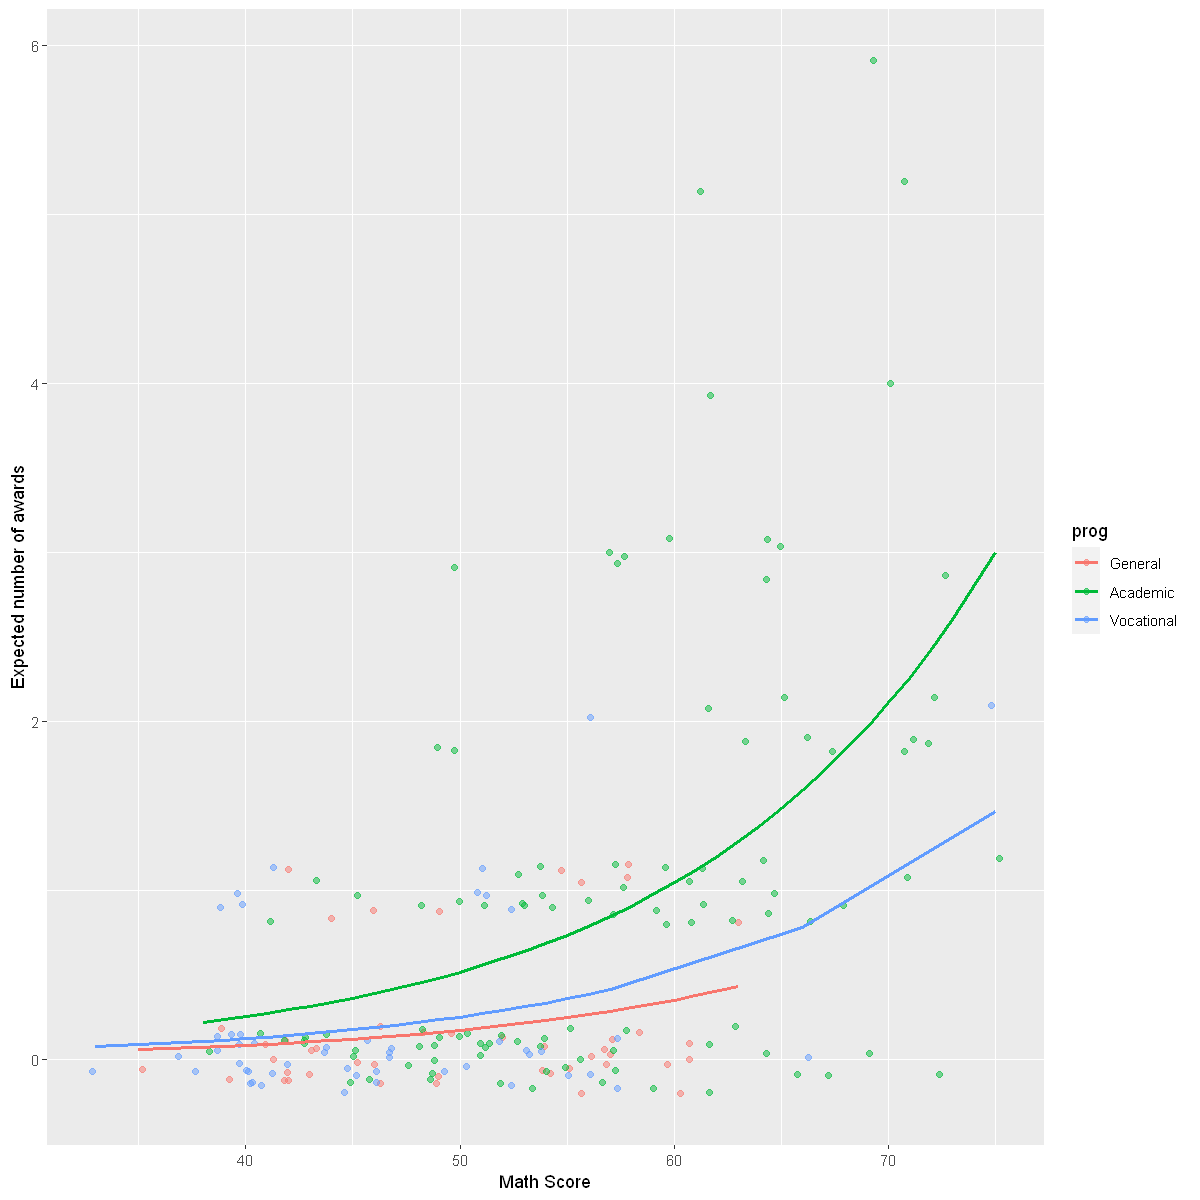

In [42]:
## calculate and store predicted values
p$phat <- predict(m1, type="response")

## order by program and then by math
p <- p[with(p, order(prog, math)), ]

## create the plot
ggplot(p, aes(x = math, y = phat, colour = prog)) +
  geom_point(aes(y = num_awards), alpha=.5, position=position_jitter(h=.2)) +
  geom_line(size = 1) +
  labs(x = "Math Score", y = "Expected number of awards")